In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import collections
import random
import time
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [3]:
from grid_method import *
from model import GHH

In [4]:
def get_region_1d(grad):
    grad_n = grad.numpy()
    grad_n = grad_n.reshape(-1)
    sp = grad_n.shape
    grad_n = grad_n.astype(str)
    _, dist = np.unique(grad_n, return_inverse = True)
    dist = dist.reshape(sp)
    return dist

In [5]:
def arch_1(d, k, l):
    ghh1 = GHH(d,1,k)
    res = ghh1(d)
    
    for i in range(l-1):
        ghh = GHH(d,1,k)
        res = res.clone()
        res = ghh(res)
        
    output = res.clone()
    return output

In [123]:
def nb_region_arch1(ls, n_iter, window_size, nb, save_name1, save_name2, save_name):
    avg_nbs = []
    stds = []
    for l in ls:
        stats = torch.empty(n_iter, 1)
        size_prev = np.array([])
        
        for i in range(n_iter):
            d = torch.linspace(-1*window_size, window_size, nb)
            d = d.reshape(-1, 1)
            d.requires_grad_(True)
            output = arch_1(d, 3, l)
            output.backward(torch.ones_like(output))
            grad = d.grad.numpy().reshape(-1)
            
            stats[i,0] = len(set(grad))
            grad_value = np.unique(grad)
            sizes = np.empty(grad_value.shape)
            
            for j in range(len(grad_value)):
                g = grad_value[j]
                sizes[j] = np.sum(grad==g)
                
            region_size = np.hstack((size_prev, sizes))
            size_prev = sizes
        avg_nb = stats.mean(axis = 0)[0].item()
        std = stats.std(axis = 0)[0].item()
        avg_nbs.append(avg_nb)
        stds.append(std)
        np.save(save_name, region_size)
        print(f'{l}, finished.')
    # save the result
    avg_nbs_tosave = np.array(avg_nbs)
    stds_tosave = np.array(stds)
    np.save(save_name1, avg_nbs_tosave)
    np.save(save_name2, stds_tosave)
    return avg_nbs, stds, region_size

In [124]:
def size_region(l, n_iter, window_size, nb, save_name):
    size_prev = np.array([])
    for i in range(n_iter):
        d = torch.linspace(-1*window_size, window_size, nb)
        d = d.reshape(-1, 1)
        d.requires_grad_(True)
        output = arch_1(d, 3, l)
        output.backward(torch.ones_like(output))
        grad = d.grad.numpy().reshape(-1)

        grad_value = np.unique(grad)
        sizes = np.empty(grad_value.shape)
            
        for j in range(len(grad_value)):
            g = grad_value[j]
            sizes[j] = np.sum(grad==g)
                
        region_size = np.hstack((size_prev, sizes))
        size_prev = region_size
        
        
    np.save(save_name, region_size)
    
    return region_size

In [72]:
ls = 100
n_iter = 10000
window_size = 40
nb = 8001
save_name = 'W10/data/dist_size_region_L100_stepsize001.npy'

In [73]:
region_size = size_region(ls, n_iter, window_size, nb, save_name)

In [75]:
ls = 100
n_iter = 10000
window_size = 40
nb = 80001
save_name = 'W10/data/dist_size_region_L100_stepsize0001.npy'

In [76]:
region_size = size_region(ls, n_iter, window_size, nb, save_name)

In [77]:
ls = 80
n_iter = 10000
window_size = 40
nb = 80001
save_name = 'W10/data/dist_size_region_L80_stepsize0001.npy'

In [78]:
region_size = size_region(ls, n_iter, window_size, nb, save_name)

In [125]:
ls = 40
n_iter = 10000
window_size = 40
nb = 80001
save_name = 'W10/data/dist_size_region_L40_stepsize0001.npy'

In [126]:
region_size = size_region(ls, n_iter, window_size, nb, save_name)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1920024 bytes. Buy new RAM!

### plot the histogram

In [6]:
region_size1 = np.load('W10/data/dist_size_region_L100_stepsize001.npy')

region_size2 = np.load('W10/data/dist_size_region_L100_stepsize0001.npy')

region_size3 = np.load('W10/data/dist_size_region_L80_stepsize0001.npy')

In [7]:
region_size1 = region_size1.ravel()

region_size2 = region_size2.ravel()

region_size3 = region_size3.ravel()

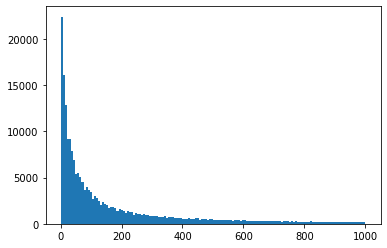

In [98]:
plt.hist(region_size1[region_size1<=1000], bins='auto') 
plt.show()

In [8]:
np.sum(region_size1<=10)

29834

In [9]:
region_size1.shape

(229174,)

In [10]:
np.sum(region_size1<=10)/region_size1.shape[0]

0.13018056149475943

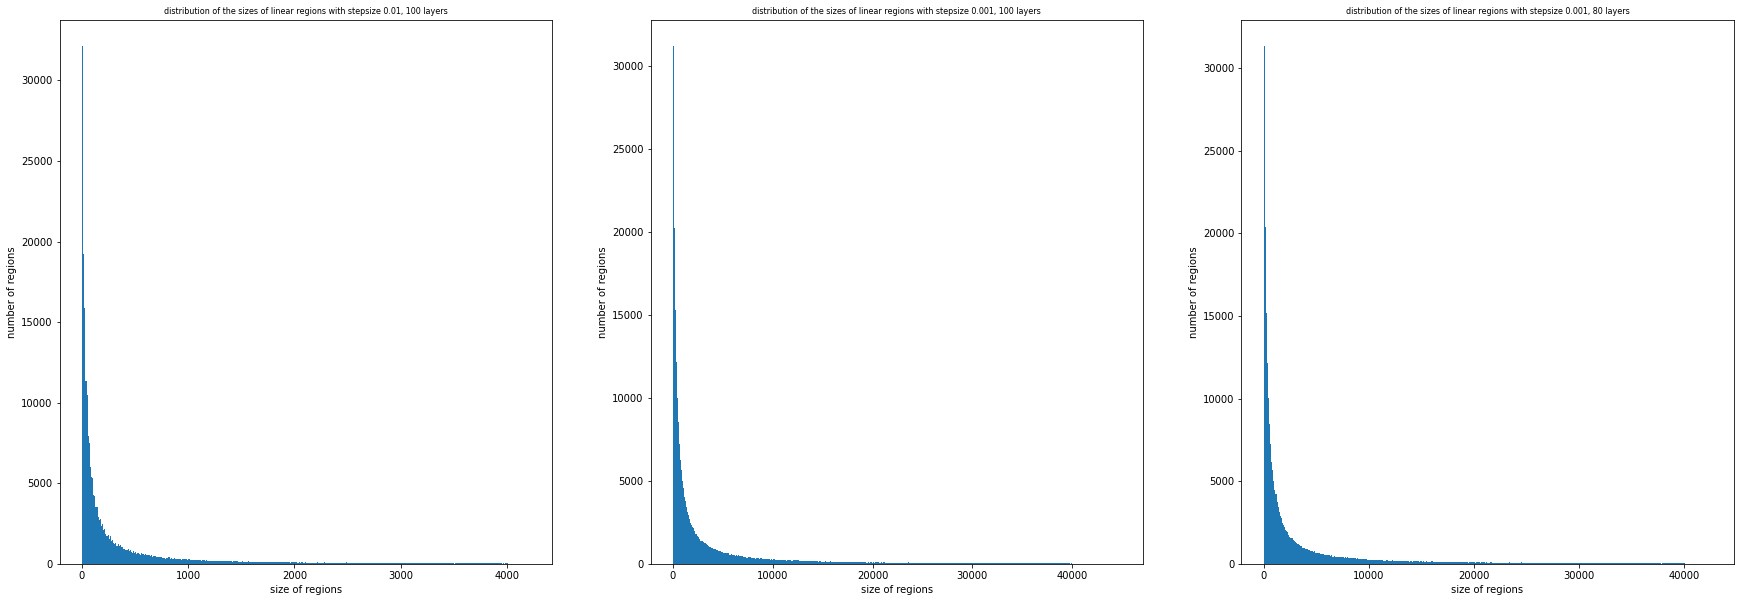

In [11]:
# plotting
fig = plt.figure(figsize=(30,10))
plt.subplot(1, 3, 1)
plt.hist(region_size1, bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.01, 100 layers",fontsize=8)

plt.subplot(1, 3, 2)
plt.hist(region_size2, bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 100 layers",fontsize=8)

plt.subplot(1, 3, 3)
plt.hist(region_size3, bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 80 layers",fontsize=8)

plt.savefig('W10/dist_size_linear_regions1.jpg')
plt.show()

Text(0.5, 1.0, 'distribution of the sizes of linear regions with stepsize 0.01, 100 layers')

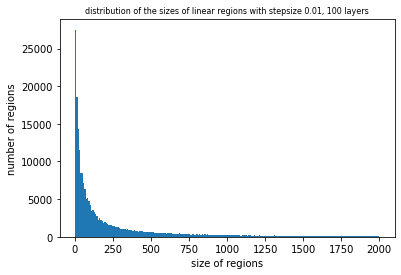

In [12]:
plt.hist(region_size1[region_size1<=2000], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.01, 100 layers",fontsize=8)

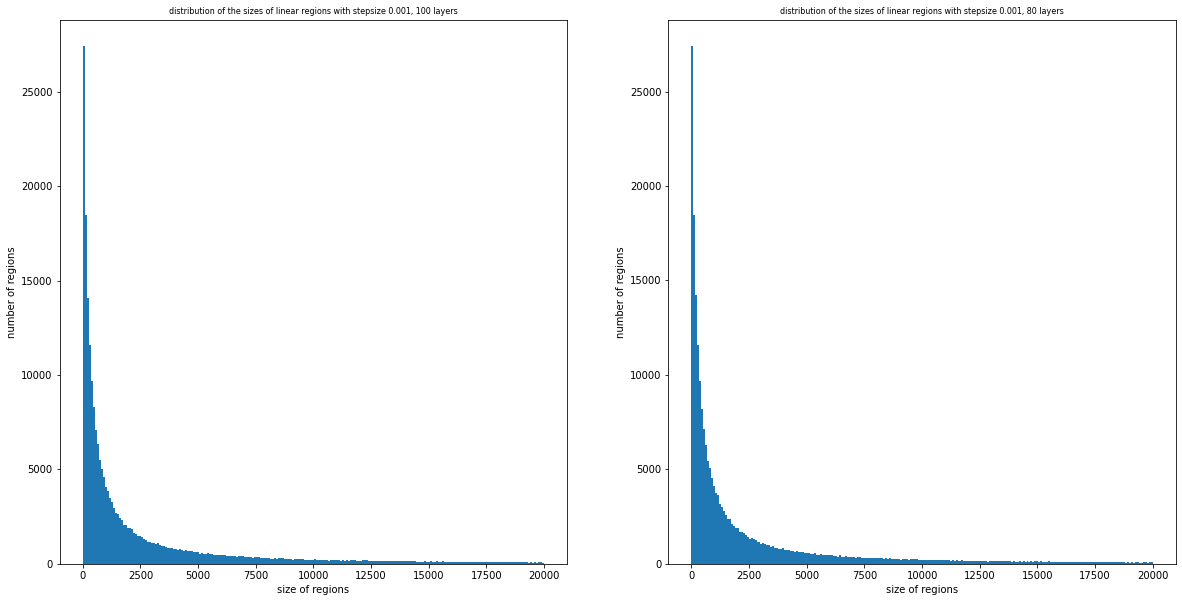

In [13]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.hist(region_size2[region_size2<=20000], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 100 layers",fontsize=8)

plt.subplot(1, 2, 2)
plt.hist(region_size3[region_size3<=20000], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 80 layers",fontsize=8)

plt.show()

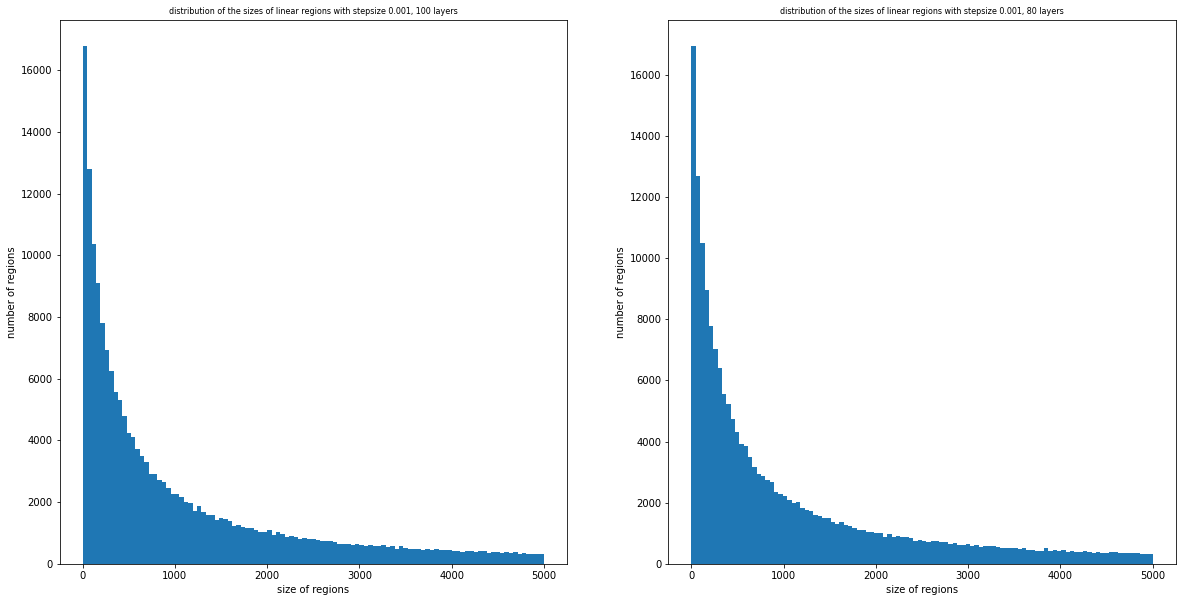

In [14]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.hist(region_size2[region_size2<=5000], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 100 layers",fontsize=8)

plt.subplot(1, 2, 2)
plt.hist(region_size3[region_size3<=5000], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 80 layers",fontsize=8)

plt.show()

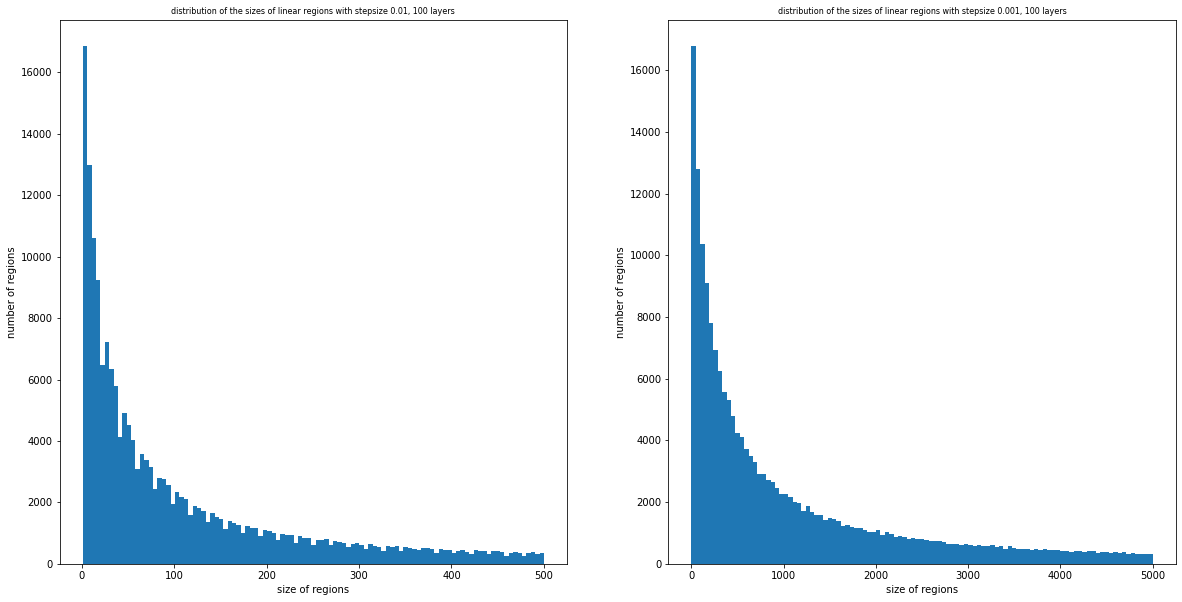

In [15]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.hist(region_size1[region_size1<=500], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.01, 100 layers",fontsize=8)

plt.subplot(1, 2, 2)
plt.hist(region_size2[region_size2<=5000], bins = 'auto')

plt.xlabel("size of regions")
plt.ylabel("number of regions")
plt.title("distribution of the sizes of linear regions with stepsize 0.001, 100 layers",fontsize=8)

plt.show()

In [105]:
np.sum(region_size1 <=1),np.sum(region_size2 <=1),np.sum(region_size3 <=1)

(3764, 446, 454)

In [16]:
np.sum(region_size1<=1)/region_size1.shape[0]

0.01642420169827293

In [17]:
np.sum(region_size2<=10)/region_size2.shape[0]

0.017547343293375175

In [18]:
np.sum(region_size3<=10)/region_size3.shape[0]

0.017841875728658405

In [106]:
np.sum(region_size1 <=10),np.sum(region_size2 <=10),np.sum(region_size3 <=10)

(29834, 4065, 4132)

In [107]:
np.sum(region_size1 <=100),np.sum(region_size2 <=100),np.sum(region_size3 <=100)

(118800, 30566, 30856)

In [ ]:
np.sum()